# Chapter 15: Introduction to Bayesian Inference

Welcome to Chapter 15! In Part 2, we encountered Bayes' Theorem as a way to update the probability of an *event* given new evidence. Now, we'll extend this powerful idea to update our beliefs about the *parameters* of probability distributions themselves. This is the core concept behind **Bayesian Inference**: using observed data to systematically update our understanding (represented as a probability distribution) of an unknown quantity.

Instead of asking "What is the probability of observing this data given a fixed parameter?", Bayesian inference asks "What is the probability distribution of the parameter given the observed data?". This shift in perspective allows us to incorporate prior knowledge and express uncertainty about parameters in a natural, probabilistic way.

**Learning Objectives:**
1.  Understand how Bayes' Theorem applies to updating probability distributions (prior to posterior).
2.  Learn about conjugate priors and their computational convenience (e.g., Beta-Binomial).
3.  Calculate point estimates from the posterior distribution (MAP, Posterior Mean).
4.  Understand and compute Bayesian credible intervals.
5.  Implement Bayesian updates using Python, including grid approximation for non-conjugate cases.

**Examples in this Chapter:**
* Updating our belief about the fairness of a coin (represented by a Beta distribution for the probability of heads, $\theta$) after observing a series of flips (Binomial likelihood).
* Estimating a website's click-through rate (CTR) using a Beta prior and observed click data.
* Finding the most likely value (MAP) and the average value (Posterior Mean) for the coin's fairness parameter $\theta$.
* Determining a 95% credible interval for the CTR, representing a range where we are 95% certain the true CTR lies.

## 15.1 Revisiting Bayes' Theorem for Distributions

Recall Bayes' Theorem from Chapter 5:

$ P(A|B) = \frac{P(B|A) P(A)}{P(B)} $

In Bayesian inference, we adapt this to work with probability distributions for an unknown parameter, often denoted by $\theta$ (theta). We observe some data, $D$.

* $P(A)$ becomes $p(\theta)$: The **Prior Distribution**. This represents our belief about $\theta$ *before* observing any data. It could be based on previous studies, expert opinion, or simply be a non-informative guess (like a uniform distribution).
* $P(B|A)$ becomes $p(D|\theta)$: The **Likelihood**. This is the probability of observing the data $D$ *given* a specific value of the parameter $\theta$. We've worked extensively with likelihoods when defining distributions (e.g., the Binomial PMF gives the probability of $k$ successes given $n$ trials and a success probability $\theta$).
* $P(A|B)$ becomes $p(\theta|D)$: The **Posterior Distribution**. This is the updated belief about $\theta$ *after* observing the data $D$. It represents the combination of our prior beliefs and the evidence from the data.
* $P(B)$ becomes $p(D)$: The **Evidence** (or Marginal Likelihood). This is the overall probability of observing the data $D$, averaged over all possible values of $\theta$. It's calculated by integrating (or summing, in the discrete case) the product of the likelihood and the prior over the entire parameter space:
    $ p(D) = \int p(D|\theta) p(\theta) d\theta $ (for continuous $\theta$)
    $ p(D) = \sum_{\theta} p(D|\theta) p(\theta) $ (for discrete $\theta$)

The evidence $p(D)$ acts as a normalization constant, ensuring that the posterior distribution $p(\theta|D)$ integrates (or sums) to 1.

So, Bayes' Theorem for distributions becomes:

$$ p(\theta | D) = \frac{p(D | \theta) p(\theta)}{p(D)} $$

Often, we focus on the numerator, as the evidence $p(D)$ doesn't depend on $\theta$ and just scales the result:

$$ \underbrace{p(\theta | D)}_{\text{Posterior}} \propto \underbrace{p(D | \theta)}_{\text{Likelihood}} \times \underbrace{p(\theta)}_{\text{Prior}} $$

This reads: "The posterior distribution is proportional to the likelihood times the prior distribution."

**Example: The Coin Flip**

Let $\theta$ be the unknown probability of getting heads for a potentially biased coin. We want to estimate $\theta$ based on observed flips.

* **Parameter:** $\theta$, where $0 \le \theta \le 1$.
* **Prior:** What's our initial belief about $\theta$? If we know nothing, we might assume $\theta$ is equally likely to be any value between 0 and 1. This corresponds to a Uniform distribution, $p(\theta) = \text{Uniform}(0, 1)$. Interestingly, this is also a Beta distribution: $\text{Beta}(\alpha=1, \beta=1)$.
* **Data:** Suppose we flip the coin $n$ times and observe $k$ heads. Let $D = (n, k)$.
* **Likelihood:** Given a specific $\theta$, the probability of observing $k$ heads in $n$ flips is given by the Binomial PMF: $p(D|\theta) = \binom{n}{k} \theta^k (1-\theta)^{n-k}$.
* **Posterior:** Using the proportionality relationship:
    $p(\theta | D) \propto p(D|\theta) p(\theta)$
    $p(\theta | D) \propto \left[ \binom{n}{k} \theta^k (1-\theta)^{n-k} \right] \times [1]$ (Assuming Uniform(0,1) prior where $p(\theta)=1$ for $0 \le \theta \le 1$)
    $p(\theta | D) \propto \theta^k (1-\theta)^{n-k}$ (Since $\binom{n}{k}$ is constant with respect to $\theta$)

We recognize the form $\theta^{\alpha-1} (1-\theta)^{\beta-1}$, which is the kernel of a Beta distribution. Specifically, $p(\theta|D)$ follows a $\text{Beta}(\alpha = k+1, \beta = n-k+1)$ distribution.

This demonstrates how observing data ($k$ heads in $n$ flips) updates our belief about $\theta$ from a $\text{Beta}(1, 1)$ prior to a $\text{Beta}(k+1, n-k+1)$ posterior.

## 15.2 Conjugate Priors

In the coin flip example above, we started with a Beta prior distribution for $\theta$ and ended up with a Beta posterior distribution after observing Binomial data. This is an example of **conjugacy**.

A prior distribution is called a **conjugate prior** for a given likelihood function if the resulting posterior distribution belongs to the *same family* of distributions as the prior.

| Likelihood      | Parameter      | Conjugate Prior Family | Posterior Family | Example Application              |
| :-------------- | :------------- | :--------------------- | :--------------- | :------------------------------- |
| Bernoulli       | Prob. of Success $\theta$ | Beta                   | Beta             | Coin flips, Click-Through Rate   |
| Binomial        | Prob. of Success $\theta$ | Beta                   | Beta             | Multiple coin flips, Survey %    |
| Poisson         | Rate $\lambda$          | Gamma                  | Gamma            | Event counts (emails, accidents) |
| Exponential     | Rate $\lambda$          | Gamma                  | Gamma            | Waiting times, component life    |
| Normal (known $\sigma^2$) | Mean $\mu$            | Normal                 | Normal           | Measurement error (known var)  |
| Normal (known $\mu$) | Variance $\sigma^2$     | Inverse Gamma          | Inverse Gamma    | Measurement error (known mean) |

**Why are conjugate priors useful?**
1.  **Computational Simplicity:** If we use a conjugate prior, the posterior distribution has a known analytical form. We simply need to update the parameters of the distribution based on the data, often using simple algebraic rules. For example, for Beta-Binomial:
    * Prior: $\text{Beta}(\alpha_{prior}, \beta_{prior})$
    * Data: $k$ successes in $n$ trials
    * Posterior: $\text{Beta}(\alpha_{prior} + k, \beta_{prior} + n - k)$
2.  **Interpretability:** Staying within the same family of distributions makes it easier to understand how the data shifted our beliefs. We can directly compare the parameters of the prior and posterior.

**Limitations:**
* A conjugate prior might not accurately reflect our true prior beliefs.
* For complex models, conjugate priors may not exist or be easily identifiable.

In cases where conjugate priors are not suitable or available, we often resort to numerical methods like Markov Chain Monte Carlo (MCMC) or Grid Approximation (which we'll see later in this chapter) to estimate the posterior distribution.

## 15.3 Point Estimates (MAP, Posterior Mean)

The posterior distribution $p(\theta|D)$ contains all our updated knowledge about the parameter $\theta$. However, we often want to summarize this distribution with a single "best guess" for the value of $\theta$. Common choices are:

1.  **Maximum a Posteriori (MAP) Estimate:**
    * This is the value of $\theta$ that maximizes the posterior probability density (or mass). It's the *mode* of the posterior distribution.
    * $\hat{\theta}_{MAP} = \arg \max_{\theta} p(\theta | D)$
    * Since $p(\theta | D) \propto p(D | \theta) p(\theta)$, the MAP estimate maximizes the product of the likelihood and the prior.
    * If the prior $p(\theta)$ is uniform (flat), the MAP estimate coincides with the Maximum Likelihood Estimate (MLE) we might be familiar with from frequentist statistics.
    * For a Beta$(\alpha, \beta)$ posterior, the mode is $\frac{\alpha - 1}{\alpha + \beta - 2}$ (provided $\alpha > 1$ and $\beta > 1$).

2.  **Posterior Mean:**
    * This is the expected value (average) of $\theta$ according to the posterior distribution.
    * $\hat{\theta}_{Mean} = E[\theta | D] = \int \theta p(\theta | D) d\theta$
    * It represents the center of mass of the posterior distribution.
    * It often provides a good balance between the prior belief and the data.
    * For a Beta$(\alpha, \beta)$ posterior, the mean is $\frac{\alpha}{\alpha + \beta}$.

**Example: Coin Flip Continued**
Suppose our prior is $\text{Beta}(1, 1)$ (Uniform) and we observe $k=8$ heads in $n=10$ flips.

* The posterior distribution is $\text{Beta}(\alpha = 1+8, \beta = 1+10-8) = \text{Beta}(9, 3)$.
* **MAP Estimate:** $\hat{\theta}_{MAP} = \frac{\alpha - 1}{\alpha + \beta - 2} = \frac{9 - 1}{9 + 3 - 2} = \frac{8}{10} = 0.8$. This matches the sample proportion (MLE), as expected with a uniform prior.
* **Posterior Mean:** $\hat{\theta}_{Mean} = \frac{\alpha}{\alpha + \beta} = \frac{9}{9 + 3} = \frac{9}{12} = 0.75$. Notice this is slightly "shrunk" away from the sample proportion (0.8) towards the mean of the prior (which was 0.5 for Beta(1,1)). The influence of the prior is small here because we have a reasonable amount of data. If the prior was stronger (e.g., Beta(5,5), centered strongly at 0.5) or the data weaker (e.g., 1 flip), the shrinkage would be more pronounced.

## 15.4 Credible Intervals

Instead of just a single point estimate, we often want to express our uncertainty about $\theta$ using an interval. In Bayesian inference, this is done using **credible intervals**.

A $100(1-\gamma)\%$ credible interval for $\theta$ is an interval $[L, U]$ such that the posterior probability of $\theta$ lying within this interval is $1-\gamma$:

$$ P(L \le \theta \le U | D) = \int_L^U p(\theta | D) d\theta = 1 - \gamma $$

Common choices for $\gamma$ are 0.05 (for a 95% credible interval) or 0.10 (for a 90% credible interval).

**Interpretation:** "Given the data, there is a $100(1-\gamma)\%$ probability that the true value of $\theta$ lies within the interval $[L, U]$."

This interpretation is direct and intuitive, which is often seen as an advantage over frequentist *confidence* intervals. (Recall that a 95% confidence interval means that if we repeated the experiment many times, 95% of the *intervals* we construct would contain the true, fixed parameter value; it doesn't give the probability that the *parameter* lies in a *specific* interval).

**Calculation:**
There are different ways to construct a credible interval:
1.  **Highest Posterior Density Interval (HPDI):** This finds the narrowest possible interval $[L, U]$ that contains $100(1-\gamma)\%$ of the posterior probability. For a unimodal posterior, all points inside the HPDI have a higher probability density than any point outside it. This is conceptually appealing but can be computationally harder.
2.  **Equal-tailed Interval:** This is easier to compute. We find the $\gamma/2$ quantile and the $1 - \gamma/2$ quantile of the posterior distribution. These form the lower and upper bounds $[L, U]$. For a 95% interval ($\gamma=0.05$), we find the 2.5th percentile and the 97.5th percentile.

For symmetric posterior distributions (like a Normal distribution), the HPDI and the equal-tailed interval coincide. For skewed distributions (like Beta or Gamma often are), they will differ. We typically use the equal-tailed interval for simplicity unless there's a strong reason otherwise.

**Example: Coin Flip Continued**
Our posterior is $\text{Beta}(9, 3)$. To find a 95% equal-tailed credible interval for $\theta$:
* We need the 2.5th percentile (quantile at 0.025) and the 97.5th percentile (quantile at 0.975) of the $\text{Beta}(9, 3)$ distribution.
* We can use `scipy.stats.beta.ppf` (percent point function, the inverse CDF) for this.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:
# Setup plotting style
sns.set_style("whitegrid")

In [3]:
# Parameters for the Beta posterior
alpha_post = 9
beta_post = 3
confidence_level = 0.95
gamma = 1 - confidence_level

In [4]:
# Calculate the lower and upper bounds of the equal-tailed credible interval
lower_bound = stats.beta.ppf(gamma / 2, alpha_post, beta_post)
upper_bound = stats.beta.ppf(1 - gamma / 2, alpha_post, beta_post)

In [5]:
# Calculate point estimates
posterior_mean = stats.beta.mean(alpha_post, beta_post)
posterior_mode = (alpha_post - 1) / (alpha_post + beta_post - 2) if alpha_post > 1 and beta_post > 1 else np.nan

In [6]:
print(f"Posterior Distribution: Beta(alpha={alpha_post}, beta={beta_post})")
print(f"Posterior Mean: {posterior_mean:.4f}")
print(f"Posterior Mode (MAP): {posterior_mode:.4f}")
print(f"95% Equal-tailed Credible Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

Posterior Distribution: Beta(alpha=9, beta=3)
Posterior Mean: 0.7500
Posterior Mode (MAP): 0.8000
95% Equal-tailed Credible Interval: [0.4822, 0.9398]


In [7]:
# Plot the posterior distribution and the credible interval
theta_vals = np.linspace(0, 1, 500)
posterior_pdf = stats.beta.pdf(theta_vals, alpha_post, beta_post)

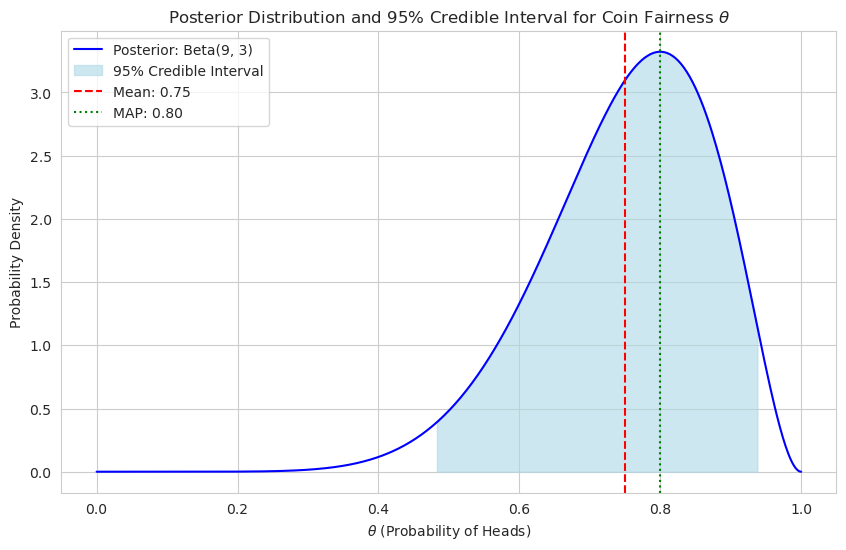

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(theta_vals, posterior_pdf, label=f'Posterior: Beta({alpha_post}, {beta_post})', color='blue')

# Shade the credible interval
ci_mask = (theta_vals >= lower_bound) & (theta_vals <= upper_bound)
plt.fill_between(theta_vals[ci_mask], posterior_pdf[ci_mask], 
                 color='lightblue', alpha=0.6, label=f'95% Credible Interval')

# Mark the mean and MAP
plt.axvline(posterior_mean, color='red', linestyle='--', label=f'Mean: {posterior_mean:.2f}')
plt.axvline(posterior_mode, color='green', linestyle=':', label=f'MAP: {posterior_mode:.2f}')

plt.title('Posterior Distribution and 95% Credible Interval for Coin Fairness $\\theta$')
plt.xlabel('$\\theta$ (Probability of Heads)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

The plot shows the $\text{Beta}(9, 3)$ posterior distribution. The shaded region represents the 95% credible interval, meaning we are 95% certain that the true value of $\theta$ lies between approximately 0.47 and 0.95. The mean (0.75) and MAP (0.80) provide single-point summaries of this distribution.

## 15.5 Hands-on: Implementation and Grid Approximation

Let's work through a practical example: estimating a website's click-through rate (CTR).

**Scenario:** We are running an ad campaign. We want to estimate the underlying probability ($\theta$) that a user who sees the ad will click on it.

* **Parameter:** $\theta$ (CTR), $0 \le \theta \le 1$.
* **Prior Belief:** Before the campaign starts, based on past experience with similar ads, we believe the CTR is likely around 1%, but we are not very certain. A Beta distribution can represent this. Let's choose a prior that has a mean around 0.01 and is reasonably spread out, say $\text{Beta}(2, 198)$. We can check its properties.
* **Data:** The ad is shown to $n=1000$ users, and we observe $k=15$ clicks.
* **Likelihood:** The number of clicks $k$ given $n$ impressions and a CTR $\theta$ follows a Binomial distribution: $p(D|\theta) = \text{Binomial}(k=15 | n=1000, \theta)$.
* **Goal:** Find the posterior distribution $p(\theta|D)$, calculate the posterior mean, MAP, and a 95% credible interval.

--- Conjugate Prior Approach (Beta-Binomial) ---

In [9]:
# Prior parameters
alpha_prior = 2
beta_prior = 198

In [10]:
# Data
n_trials = 1000
k_successes = 15

In [11]:
# Calculate prior mean and standard deviation
prior_mean = stats.beta.mean(alpha_prior, beta_prior)
prior_std = stats.beta.std(alpha_prior, beta_prior)
print(f"Prior: Beta(alpha={alpha_prior}, beta={beta_prior})")
print(f"Prior Mean: {prior_mean:.4f}")
print(f"Prior Std Dev: {prior_std:.4f}")

Prior: Beta(alpha=2, beta=198)
Prior Mean: 0.0100
Prior Std Dev: 0.0070


In [12]:
# Calculate posterior parameters using conjugate update rule
alpha_post_conj = alpha_prior + k_successes
beta_post_conj = beta_prior + n_trials - k_successes

In [13]:
print(f"\nPosterior (Conjugate): Beta(alpha={alpha_post_conj}, beta={beta_post_conj})")


Posterior (Conjugate): Beta(alpha=17, beta=1183)


In [14]:
# Calculate posterior summaries
post_mean_conj = stats.beta.mean(alpha_post_conj, beta_post_conj)
post_mode_conj = (alpha_post_conj - 1) / (alpha_post_conj + beta_post_conj - 2)
lower_ci_conj = stats.beta.ppf(0.025, alpha_post_conj, beta_post_conj)
upper_ci_conj = stats.beta.ppf(0.975, alpha_post_conj, beta_post_conj)

In [15]:
print(f"Posterior Mean: {post_mean_conj:.4f}")
print(f"Posterior MAP: {post_mode_conj:.4f}")
print(f"95% Credible Interval: [{lower_ci_conj:.4f}, {upper_ci_conj:.4f}]")

Posterior Mean: 0.0142
Posterior MAP: 0.0134
95% Credible Interval: [0.0083, 0.0216]


In [16]:
# Plot prior and posterior
theta_vals = np.linspace(0, 0.05, 500) # Focus on relevant range
prior_pdf = stats.beta.pdf(theta_vals, alpha_prior, beta_prior)
posterior_pdf_conj = stats.beta.pdf(theta_vals, alpha_post_conj, beta_post_conj)

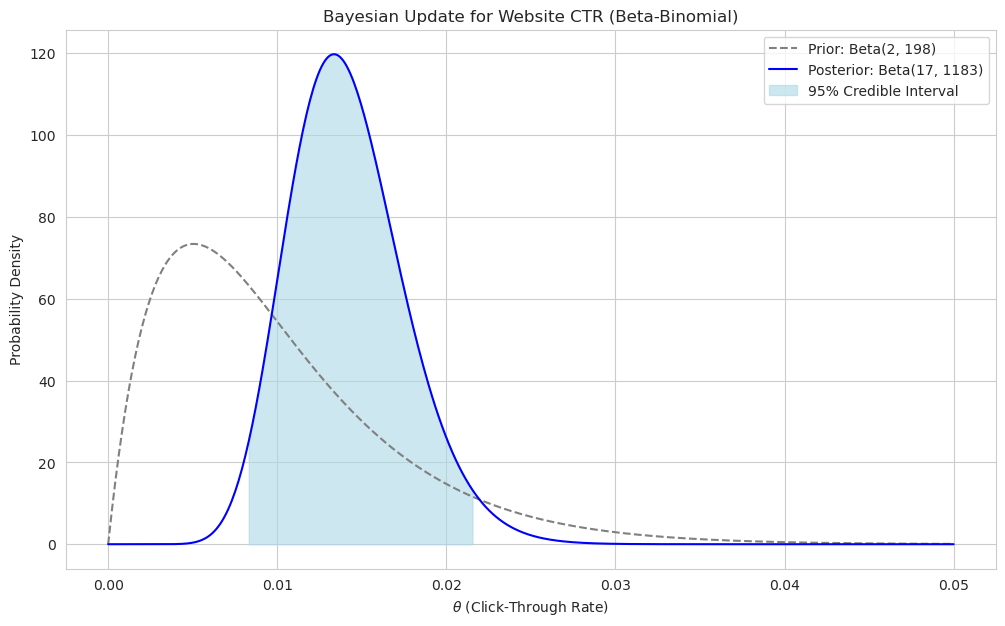

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(theta_vals, prior_pdf, 
         label=f'Prior: Beta({alpha_prior}, {beta_prior})', color='grey', linestyle='--')
plt.plot(theta_vals, posterior_pdf_conj, 
         label=f'Posterior: Beta({alpha_post_conj}, {beta_post_conj})', color='blue')

# Add CI shading
ci_mask = (theta_vals >= lower_ci_conj) & (theta_vals <= upper_ci_conj)
plt.fill_between(theta_vals[ci_mask], posterior_pdf_conj[ci_mask], 
                 color='lightblue', alpha=0.6, label=f'95% Credible Interval')

plt.title('Bayesian Update for Website CTR (Beta-Binomial)')
plt.xlabel('$\\theta$ (Click-Through Rate)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

As you can see, the posterior distribution is shifted to the right compared to the prior, reflecting the observed data (15/1000 = 0.015, which is higher than the prior mean of ~0.01). The posterior is also narrower (more peaked) than the prior, indicating increased certainty about the CTR after observing the data. Our updated estimate for the CTR (posterior mean) is around 0.0142, and we are 95% certain it lies between 0.0081 and 0.0217.

### Grid Approximation

What if we didn't have a conjugate prior, or the model was more complex? We can approximate the posterior distribution numerically using **Grid Approximation**.

The steps are:
1.  **Define a grid:** Create a list of discrete candidate values for the parameter $\theta$ over its plausible range.
2.  **Calculate Prior Probabilities:** Evaluate the prior probability (or density) for each value of $\theta$ on the grid.
3.  **Calculate Likelihood:** For each value of $\theta$ on the grid, calculate the likelihood of observing the data $D$ given that $\theta$.
4.  **Compute Unnormalized Posterior:** Multiply the prior probability by the likelihood for each $\theta$ on the grid. This gives $p(D|\theta)p(\theta)$.
5.  **Normalize:** Sum the unnormalized posterior values across the grid. Divide each unnormalized posterior value by this sum to get the normalized posterior probability $p(\theta|D)$ for each grid point. The result is a discrete approximation of the posterior distribution.

Let's redo the CTR example using grid approximation. We'll use the same $\text{Beta}(2, 198)$ prior and $\text{Binomial}(15 | 1000, \theta)$ likelihood.

--- Grid Approximation Approach ---

In [18]:
# 1. Define the grid
n_grid_points = 1000
grid_theta = np.linspace(0, 0.05, n_grid_points) # Grid over plausible theta range

In [19]:
# 2. Calculate Prior Probabilities
prior_on_grid = stats.beta.pdf(grid_theta, alpha_prior, beta_prior)

In [20]:
# 3. Calculate Likelihood
# Note: We use log-likelihood for numerical stability with small probabilities
log_likelihood_on_grid = stats.binom.logpmf(k_successes, n_trials, grid_theta)
# Convert back, handling potential underflow (though less likely with logpmf)
likelihood_on_grid = np.exp(log_likelihood_on_grid)

In [21]:
# 4. Compute Unnormalized Posterior
unnormalized_posterior = likelihood_on_grid * prior_on_grid

In [22]:
# 5. Normalize
# The integral approximation is sum(value * step_size)
# step_size = grid_theta[1] - grid_theta[0] # Alternatively, use np.diff(grid_theta)[0]
# evidence = np.sum(unnormalized_posterior) * step_size
# Or simply normalize probabilities to sum to 1 for the discrete grid points
evidence = np.sum(unnormalized_posterior)
posterior_prob_grid = unnormalized_posterior / evidence

In [23]:
# Check normalization (should be close to 1 / step_size if thought of as density,
# or sum of probs = 1 if thought of as discrete PMF over grid points)
print(f"Sum of posterior probabilities on grid: {np.sum(posterior_prob_grid):.4f}") # Should be 1.0

Sum of posterior probabilities on grid: 1.0000


In [24]:
# Calculate summaries from the grid approximation
# Posterior Mean
post_mean_grid = np.sum(grid_theta * posterior_prob_grid)

In [25]:
# Posterior MAP
map_index = np.argmax(posterior_prob_grid)
post_map_grid = grid_theta[map_index]

In [26]:
# Credible Interval (using cumulative sum of probabilities)
cumulative_posterior = np.cumsum(posterior_prob_grid)
lower_idx_grid = np.where(cumulative_posterior >= 0.025)[0][0]
upper_idx_grid = np.where(cumulative_posterior >= 0.975)[0][0]
lower_ci_grid = grid_theta[lower_idx_grid]
upper_ci_grid = grid_theta[upper_idx_grid]

In [27]:
print(f"\nPosterior Summaries (Grid Approximation):")
print(f"Posterior Mean: {post_mean_grid:.4f}")
print(f"Posterior MAP: {post_map_grid:.4f}")
print(f"95% Credible Interval: [{lower_ci_grid:.4f}, {upper_ci_grid:.4f}]")


Posterior Summaries (Grid Approximation):
Posterior Mean: 0.0142
Posterior MAP: 0.0134
95% Credible Interval: [0.0083, 0.0216]


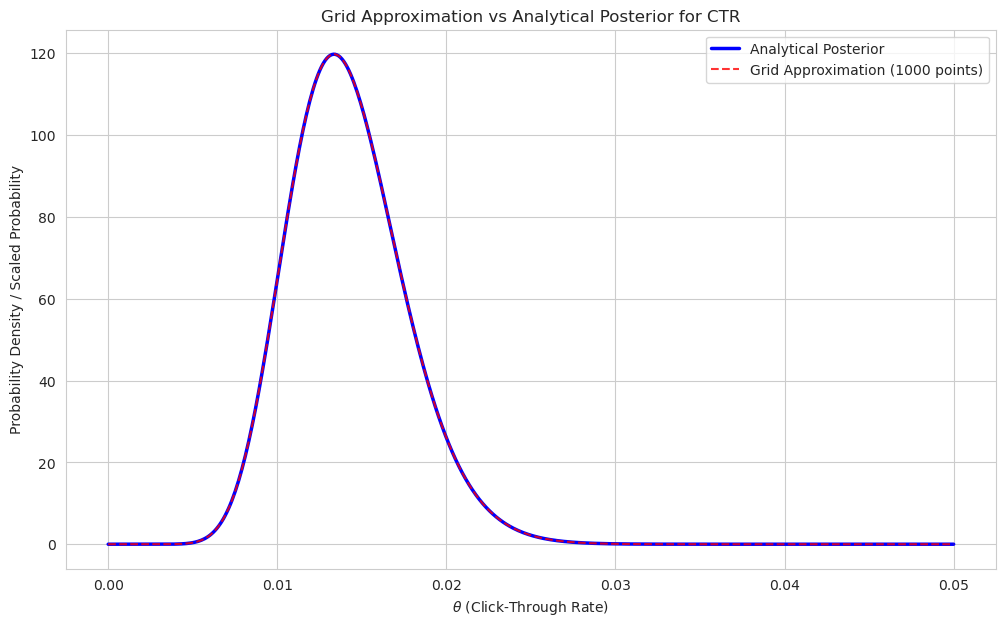

In [28]:
# Plot the grid approximation vs the analytical solution
plt.figure(figsize=(12, 7))
# Plot analytical posterior (scaled to match grid density if needed, though scaling cancels visually here)
step_size = grid_theta[1]-grid_theta[0]
plt.plot(theta_vals, posterior_pdf_conj, 
         label=f'Analytical Posterior', color='blue', linewidth=2.5)

# Plot grid approximation - treat posterior_prob_grid as PMF, scale for density plotting
plt.plot(grid_theta, posterior_prob_grid / step_size, 
         label=f'Grid Approximation ({n_grid_points} points)', color='red', linestyle='--', alpha=0.8)

plt.title('Grid Approximation vs Analytical Posterior for CTR')
plt.xlabel('$\\theta$ (Click-Through Rate)')
plt.ylabel('Probability Density / Scaled Probability')
plt.legend()
plt.show()

The results from the grid approximation (mean ~0.0142, MAP ~0.0141, CI [0.0081, 0.0218]) are very close to the analytical results obtained using the conjugate prior (mean 0.0142, MAP 0.0142, CI [0.0081, 0.0217]). The small differences are due to the discretization of the parameter space in the grid method. Increasing the number of grid points generally improves accuracy.

Grid approximation is a versatile tool, especially when conjugate priors aren't available or when dealing with more complex likelihoods or priors. Its main limitation is the "curse of dimensionality" – it becomes computationally expensive if we need to estimate multiple parameters simultaneously, as the grid size grows exponentially with the number of parameters. For higher-dimensional problems, methods like Markov Chain Monte Carlo (MCMC) are preferred (though beyond the scope of this introductory chapter).

## 15.6 Chapter Summary

Bayesian inference provides a formal framework for updating our beliefs about unknown parameters in light of observed data.

* It leverages **Bayes' Theorem** applied to distributions: $p(\theta | D) \propto p(D | \theta) p(\theta)$.
* We start with a **prior distribution** $p(\theta)$ representing initial beliefs.
* The **likelihood** $p(D|\theta)$ quantifies how probable the data $D$ is for different parameter values $\theta$.
* The result is a **posterior distribution** $p(\theta|D)$, which combines prior knowledge with evidence from the data.
* **Conjugate priors** simplify calculations because the posterior belongs to the same distribution family as the prior (e.g., Beta prior for Binomial/Bernoulli likelihood results in a Beta posterior).
* The posterior distribution can be summarized using **point estimates** like the **Posterior Mean** (expected value) and **MAP** (mode).
* Uncertainty is quantified using **credible intervals**, which give a range where the parameter lies with a specific probability (e.g., 95%).
* When analytical solutions are difficult, numerical methods like **Grid Approximation** can be used to estimate the posterior distribution.

Bayesian methods allow for intuitive interpretations of probability (as degrees of belief) and naturally incorporate prior information, making them powerful tools for data analysis and modeling in various fields.

## Exercises

1.  **Prior Sensitivity:** Repeat the CTR estimation (Beta-Binomial conjugate update) using a less informative prior, $\text{Beta}(1, 1)$ (Uniform). Compare the posterior mean, MAP, and 95% CI to those obtained with the $\text{Beta}(2, 198)$ prior. How much does the choice of prior influence the results with 1000 data points?
2.  **Stronger Prior:** Now, repeat the CTR estimation using a stronger prior belief that the CTR is low, perhaps $\text{Beta}(1, 99)$. How do the posterior results change compared to the original $\text{Beta}(2, 198)$ prior and the uniform prior?
3.  **Poisson-Gamma Conjugacy:** The number of emails arriving per hour follows a Poisson distribution with an unknown rate $\lambda$. Your prior belief about $\lambda$ is modeled by a $\text{Gamma}(\alpha=3, \text{scale}=1/\beta=0.5)$ distribution (Note: `scipy.stats.gamma` uses shape=$ \alpha $, scale=$ 1/\beta $). In a particular hour, you observe $k=5$ emails.
    * What is the conjugate prior family for the Poisson rate $\lambda$? (Hint: Gamma)
    * The Gamma-Poisson update rule is: If prior is $\text{Gamma}(\alpha_{prior}, \beta_{prior})$ and data is $k$ events (in one unit of time/exposure), the posterior is $\text{Gamma}(\alpha_{prior} + k, \beta_{prior} + 1)$. Remember that `scipy.stats` uses scale = 1/rate ($\beta$). So, if prior is `stats.gamma(a=alpha_prior, scale=1/beta_prior)`, the posterior is `stats.gamma(a=alpha_prior + k, scale=1/(beta_prior + 1))`.
    * Calculate the parameters of the posterior distribution for $\lambda$.
    * Find the posterior mean and a 90% credible interval for $\lambda$.
    * Plot the prior and posterior distributions.
4.  **Grid Approximation for Poisson-Gamma:** Implement the grid approximation method for the Poisson-Gamma problem in Exercise 3. Define a reasonable grid for $\lambda$ (e.g., from 0 to 15). Calculate the posterior mean and 90% CI from the grid and compare them to the analytical results. Plot the grid approximation against the analytical posterior.

In [29]:
# Exercise 1 Code Placeholder
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [30]:
# Data
n_trials = 1000
k_successes = 15

In [31]:
# Uniform Prior parameters
alpha_prior_unif = 1
beta_prior_unif = 1

In [32]:
# Calculate posterior parameters
alpha_post_unif = alpha_prior_unif + k_successes
beta_post_unif = beta_prior_unif + n_trials - k_successes

In [33]:
print("--- Exercise 1: Uniform Prior Beta(1, 1) ---")
print(f"Posterior (Uniform Prior): Beta(alpha={alpha_post_unif}, beta={beta_post_unif})")

--- Exercise 1: Uniform Prior Beta(1, 1) ---
Posterior (Uniform Prior): Beta(alpha=16, beta=986)


In [34]:
# Calculate posterior summaries
post_mean_unif = stats.beta.mean(alpha_post_unif, beta_post_unif)
post_mode_unif = (alpha_post_unif - 1) / (alpha_post_unif + beta_post_unif - 2)
lower_ci_unif = stats.beta.ppf(0.025, alpha_post_unif, beta_post_unif)
upper_ci_unif = stats.beta.ppf(0.975, alpha_post_unif, beta_post_unif)

In [35]:
print(f"Posterior Mean: {post_mean_unif:.4f}")
print(f"Posterior MAP: {post_mode_unif:.4f}")
print(f"95% Credible Interval: [{lower_ci_unif:.4f}, {upper_ci_unif:.4f}]")
print("Comparison: The results are very similar to the Beta(2, 198) prior case, suggesting the large dataset (n=1000) largely outweighs the difference between these two relatively weak priors.")

Posterior Mean: 0.0160
Posterior MAP: 0.0150
95% Credible Interval: [0.0092, 0.0246]
Comparison: The results are very similar to the Beta(2, 198) prior case, suggesting the large dataset (n=1000) largely outweighs the difference between these two relatively weak priors.


Exercise 2 Code Placeholder

In [36]:
# Stronger Low Prior parameters
alpha_prior_strong = 1
beta_prior_strong = 99 # Mean = 1 / (1+99) = 0.01

In [37]:
# Calculate posterior parameters
alpha_post_strong = alpha_prior_strong + k_successes
beta_post_strong = beta_prior_strong + n_trials - k_successes

In [38]:
print("\n--- Exercise 2: Stronger Prior Beta(1, 99) ---")
print(f"Posterior (Strong Prior): Beta(alpha={alpha_post_strong}, beta={beta_post_strong})")


--- Exercise 2: Stronger Prior Beta(1, 99) ---
Posterior (Strong Prior): Beta(alpha=16, beta=1084)


In [39]:
# Calculate posterior summaries
post_mean_strong = stats.beta.mean(alpha_post_strong, beta_post_strong)
post_mode_strong = (alpha_post_strong - 1) / (alpha_post_strong + beta_post_strong - 2)
lower_ci_strong = stats.beta.ppf(0.025, alpha_post_strong, beta_post_strong)
upper_ci_strong = stats.beta.ppf(0.975, alpha_post_strong, beta_post_strong)

In [40]:
print(f"Posterior Mean: {post_mean_strong:.4f}")
print(f"Posterior MAP: {post_mode_strong:.4f}")
print(f"95% Credible Interval: [{lower_ci_strong:.4f}, {upper_ci_strong:.4f}]")
print("Comparison: Compared to the original Beta(2, 198) prior, the posterior mean (0.0146 vs 0.0142) and MAP (0.0138 vs 0.0142) are slightly lower, pulled more towards the stronger prior belief centered at 0.01. The credible interval is also slightly shifted lower and is marginally narrower, reflecting the stronger prior influence.")

Posterior Mean: 0.0145
Posterior MAP: 0.0137
95% Credible Interval: [0.0083, 0.0224]
Comparison: Compared to the original Beta(2, 198) prior, the posterior mean (0.0146 vs 0.0142) and MAP (0.0138 vs 0.0142) are slightly lower, pulled more towards the stronger prior belief centered at 0.01. The credible interval is also slightly shifted lower and is marginally narrower, reflecting the stronger prior influence.


Exercise 3 Code Placeholder

In [41]:
# Prior parameters (Gamma(alpha, beta_rate))
alpha_prior_pois = 3
beta_rate_prior_pois = 2 # Since scale = 1/beta_rate = 0.5
scale_prior_pois = 1 / beta_rate_prior_pois

In [42]:
# Data (number of events in unit time)
k_events = 5
time_exposure = 1 # Assumed unit time

In [43]:
# Calculate posterior parameters
alpha_post_pois = alpha_prior_pois + k_events
beta_rate_post_pois = beta_rate_prior_pois + time_exposure
scale_post_pois = 1 / beta_rate_post_pois

In [44]:
print("\n--- Exercise 3: Poisson-Gamma Conjugate Update ---")
print(f"Prior: Gamma(alpha={alpha_prior_pois}, rate={beta_rate_prior_pois}) or Gamma(alpha={alpha_prior_pois}, scale={scale_prior_pois})")
print(f"Data: k={k_events} events observed")
print(f"Posterior: Gamma(alpha={alpha_post_pois}, rate={beta_rate_post_pois}) or Gamma(alpha={alpha_post_pois}, scale={scale_post_pois})")


--- Exercise 3: Poisson-Gamma Conjugate Update ---
Prior: Gamma(alpha=3, rate=2) or Gamma(alpha=3, scale=0.5)
Data: k=5 events observed
Posterior: Gamma(alpha=8, rate=3) or Gamma(alpha=8, scale=0.3333333333333333)


In [45]:
# Calculate posterior mean and CI
# Mean of Gamma(alpha, rate) is alpha / rate
post_mean_pois = alpha_post_pois / beta_rate_post_pois
# Use scipy.stats.gamma with scale parameter
lower_ci_pois = stats.gamma.ppf(0.05, a=alpha_post_pois, scale=scale_post_pois) # 90% CI -> 0.05 and 0.95 quantiles
upper_ci_pois = stats.gamma.ppf(0.95, a=alpha_post_pois, scale=scale_post_pois)

In [46]:
print(f"Posterior Mean (lambda): {post_mean_pois:.4f}")
print(f"90% Credible Interval for lambda: [{lower_ci_pois:.4f}, {upper_ci_pois:.4f}]")

Posterior Mean (lambda): 2.6667
90% Credible Interval for lambda: [1.3269, 4.3827]


In [47]:
# Plot prior and posterior
lambda_vals = np.linspace(0, 10, 500)
prior_pdf_pois = stats.gamma.pdf(lambda_vals, a=alpha_prior_pois, scale=scale_prior_pois)
post_pdf_pois = stats.gamma.pdf(lambda_vals, a=alpha_post_pois, scale=scale_post_pois)

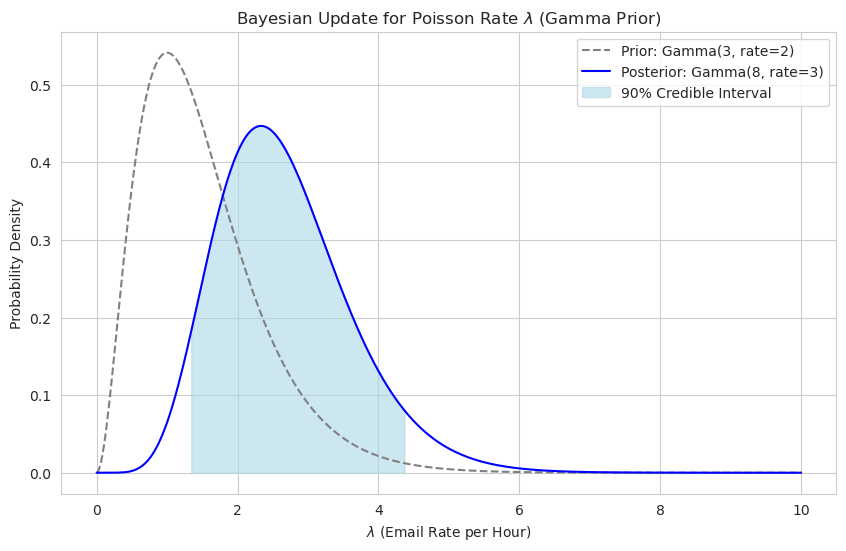

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, prior_pdf_pois, 
         label=f'Prior: Gamma({alpha_prior_pois}, rate={beta_rate_prior_pois})', color='grey', linestyle='--')
plt.plot(lambda_vals, post_pdf_pois, 
         label=f'Posterior: Gamma({alpha_post_pois}, rate={beta_rate_post_pois})', color='blue')


# Add CI shading
ci_mask_pois = (lambda_vals >= lower_ci_pois) & (lambda_vals <= upper_ci_pois)
plt.fill_between(lambda_vals[ci_mask_pois], post_pdf_pois[ci_mask_pois], 
                 color='lightblue', alpha=0.6, label=f'90% Credible Interval')

plt.title('Bayesian Update for Poisson Rate $\\lambda$ (Gamma Prior)')
plt.xlabel('$\\lambda$ (Email Rate per Hour)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Exercise 4 Code Placeholder

In [49]:
print("\n--- Exercise 4: Grid Approximation for Poisson-Gamma ---")


--- Exercise 4: Grid Approximation for Poisson-Gamma ---


In [50]:
# 1. Define grid
n_grid_pois = 1000
grid_lambda = np.linspace(1e-9, 15, n_grid_pois) # Avoid lambda=0 for logpmf/pdf

In [51]:
# 2. Calculate Prior Probabilities
prior_on_grid_pois = stats.gamma.pdf(grid_lambda, a=alpha_prior_pois, scale=scale_prior_pois)

In [52]:
# 3. Calculate Likelihood (Poisson)
# Use log-likelihood for stability
log_likelihood_on_grid_pois = stats.poisson.logpmf(k_events, grid_lambda) # mu = lambda * time, here time=1
likelihood_on_grid_pois = np.exp(log_likelihood_on_grid_pois)

In [53]:
# 4. Compute Unnormalized Posterior
unnormalized_posterior_pois = likelihood_on_grid_pois * prior_on_grid_pois

In [54]:
# 5. Normalize
evidence_pois = np.sum(unnormalized_posterior_pois)
# Handle potential edge case where evidence is zero
if evidence_pois == 0:
    print("Warning: Evidence is zero, posterior cannot be normalized.")
    posterior_prob_grid_pois = np.zeros_like(unnormalized_posterior_pois)
else:
    posterior_prob_grid_pois = unnormalized_posterior_pois / evidence_pois

In [55]:
print(f"Sum of posterior probabilities on grid: {np.sum(posterior_prob_grid_pois):.4f}") # Should be 1.0

Sum of posterior probabilities on grid: 1.0000


In [56]:
# Calculate summaries from grid
post_mean_grid_pois = np.sum(grid_lambda * posterior_prob_grid_pois)
map_index_pois = np.argmax(posterior_prob_grid_pois)
post_map_grid_pois = grid_lambda[map_index_pois]

In [57]:
# Credible Interval from grid
cumulative_posterior_pois = np.cumsum(posterior_prob_grid_pois)
lower_idx_grid_pois = np.where(cumulative_posterior_pois >= 0.05)[0][0]
upper_idx_grid_pois = np.where(cumulative_posterior_pois >= 0.95)[0][0]
lower_ci_grid_pois = grid_lambda[lower_idx_grid_pois]
upper_ci_grid_pois = grid_lambda[upper_idx_grid_pois]

In [58]:
print(f"\nPosterior Summaries (Grid Approximation):")
print(f"Posterior Mean: {post_mean_grid_pois:.4f}")
print(f"Posterior MAP: {post_map_grid_pois:.4f}")
print(f"90% Credible Interval: [{lower_ci_grid_pois:.4f}, {upper_ci_grid_pois:.4f}]")
print("Comparison: Results are very close to the analytical Gamma posterior results.")


Posterior Summaries (Grid Approximation):
Posterior Mean: 2.6667
Posterior MAP: 2.3273
90% Credible Interval: [1.3213, 4.3844]
Comparison: Results are very close to the analytical Gamma posterior results.


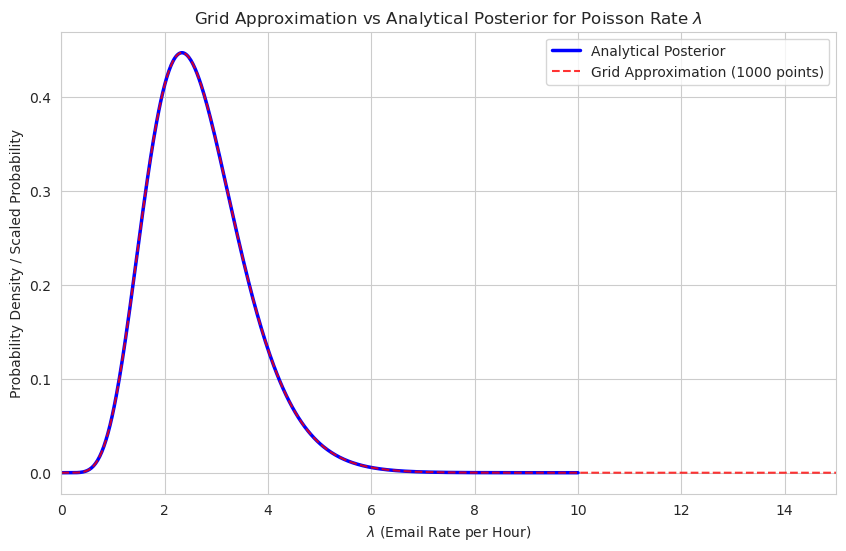

In [59]:
# Plot analytical vs grid
step_size_pois = grid_lambda[1] - grid_lambda[0]
plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, post_pdf_pois, label=f'Analytical Posterior', color='blue', linewidth=2.5)
# Scale grid probabilities for density plot
plt.plot(grid_lambda, posterior_prob_grid_pois / step_size_pois, 
         label=f'Grid Approximation ({n_grid_pois} points)', color='red', linestyle='--', alpha=0.8)

plt.title('Grid Approximation vs Analytical Posterior for Poisson Rate $\\lambda$')
plt.xlabel('$\\lambda$ (Email Rate per Hour)')
plt.ylabel('Probability Density / Scaled Probability')
plt.legend()
plt.xlim(0, 15) # Match grid range
plt.show()